In [1]:
import keras 
from keras import optimizers,regularizers,losses
from keras import losses
from keras.models import Sequential,Model
from keras.layers import Dense,Input,Dropout,Embedding,LSTM,Conv1D,Flatten,Activation,SpatialDropout1D,UpSampling1D,MaxPooling1D,ZeroPadding1D
from keras.optimizers import RMSprop,Adam,Nadam
from keras.preprocessing import sequence 
from keras.callbacks import TensorBoard,CSVLogger,ModelCheckpoint
from keras.utils import to_categorical
from keras.preprocessing import sequence 
from keras.callbacks import TensorBoard
from keras.utils import plot_model
from keras import optimizers, losses
from keras.models import Sequential,Model
from keras.layers import Dense,Input,Dropout,Embedding,concatenate
from keras.optimizers import RMSprop,Adam,Nadam
from keras.preprocessing import sequence 
from keras.callbacks import TensorBoard
from keras.utils import plot_model
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix,roc_auc_score,classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import pickle
import seaborn as sns
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import keras
import time 
import sys

Using TensorFlow backend.


## Plot the confusion matrics

In [2]:
# Visualisation class
class Visualization:
    
    labels=["Normal","Anomaly"]
    
    def drow_confusion_matrix(self,y,ypred):
        matrix=confusion_matrix(y,ypred)
        plt.figure(figsize=(15,10))
        colors=["indianred","lightseagreen"]
        sns.heatmap(matrix,xticklabels=self.labels,yticklabels=self.labels,cmap=colors,annot=True,fmt="d")
        plt.title("confusion Matrix")
        plt.ylabel('Actual')
        plt.xlabel("Predicted")
        plt.show()
    
    
    def drow_anomaly(self,y,error,threshold):
        groupsDF=pd.DataFrame({
            "error":error,
            "true":y
        }).groupby("true")
        
        figure , axes= plt.subplots(figsize=(12,8))
        for name,group in groupsDF:
            axes.plot(
                      group.index,group.error,marker="x" if name == 1 else "o",linestyle='',
                      color='r' if name==1 else "teal" , label="Anomaly" if name==1 else "Normal"
                     )
            
        axes.hlines(threshold,axes.get_xlim()[0],axes.get_xlim()[1],color="b",zorder=100,label='Thershold')
        axes.legend()
        plt.title("Anomalie")
        plt.xlabel("Data")
        plt.ylabel("Error")
        plt.show()
            
    
    def drow_error(self,error,threshold):
        plt.plot(error,marker="o",ms=3.5,linestyle="",label="Point")
        plt.hlines(threshold,xmin=0,xmax=len(error)-1,colors="b",zorder=100,label="Threshold")
        plt.legend()
        plt.title("Reconstruction Error")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()
        
            

In [3]:
df =pd.read_csv("../../../data/full_data_small_datased.csv")
df.head()

,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,MI_dir_L0.1_weight,...,HpHp_L0.1_covariance,HpHp_L0.1_pcc,HpHp_L0.01_weight,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc,Class
0,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,...,0.0,0.0,1.000000,60.000000,0.000000,60.000000,0.000000,0.0,0.0,0
1,1.000000,354.000000,0.000000,1.000000,354.000000,0.000000,1.000000,354.000000,0.000000,1.000000,...,0.0,0.0,5.319895,344.262695,4.710446,344.262695,22.188299,0.0,0.0,0
2,1.857879,360.458980,35.789338,1.912127,360.275733,35.923972,1.969807,360.091968,35.991542,1.996939,...,0.0,0.0,6.318264,347.703087,9.034660,347.703087,81.625077,0.0,0.0,0
3,1.000000,337.000000,0.000000,1.000000,337.000000,0.000000,1.000000,337.000000,0.000000,1.000000,...,0.0,0.0,1.000000,337.000000,0.000000,337.000000,0.000000,0.0,0.0,0
4,1.680223,172.140917,18487.448750,1.793580,182.560279,18928.175300,1.925828,193.165753,19153.795810,1.992323,...,0.0,0.0,1.000000,60.000000,0.000000,60.000000,0.000000,0.0,0.0,0


In [4]:
def transformer_df(df):
    dic={}
    for c in df.columns :
        if (df[c].dtype =="object"):
            encoder = LabelEncoder()
            encoder.fit(df[c])
            df[c]=encoder.transform(df[c])
            dic[c]=encoder
    with open("./models/LabelEncoders_dic.pickle","wb") as f:
        pickle.dump(dic,f)
    return df

In [5]:
def shuffle_dataframe(df):
    df = shuffle(df)
    return df

In [6]:
def normaliser_all_columns(df):
    diction={}
    
    for c in df.columns :
        scaler=MinMaxScaler(feature_range=(0,1)).fit(df[c].values.reshape(-1,1))
        diction[c]=scaler        
        df[c]=scaler.transform(df[c].values.reshape(-1,1))
    with open("./models/MinMaxScalers_dic.pickle","wb") as f:
        pickle.dump(diction,f)
    return df

In [7]:
df=transformer_df(df)
df=normaliser_all_columns(df)
df=shuffle_dataframe(df)

In [8]:
xtrain,xtest,ytrain,ytest=train_test_split(df.drop(labels=["Class"],axis=1),df["Class"],test_size=0.2)

In [9]:
def reshape_x_data_3d(xtrain):
    return np.array(xtrain).reshape(xtrain.shape[0],xtrain.shape[1],1)

def reshape_y_data_2d(ytrain):
    return keras.utils.to_categorical(ytrain,2)

In [11]:
def add_noise(xtrain,xtest,ytrain,ytest):
    noise_factor=0.3
    xtrain_noise=xtrain + noise_factor *np.random.normal(loc=0.0,scale=1.0,size=xtrain.shape)
    xtest_noise=xtest + noise_factor *np.random.normal(loc=0.0,scale=1.0,size=xtest.shape)
    ytrain_noise=ytrain + noise_factor *np.random.normal(loc=0.0,scale=1.0,size=ytrain.shape)
    ytest_noise=ytest + noise_factor *np.random.normal(loc=0.0,scale=1.0,size=ytest.shape)
    xtrain_noise=np.clip(xtrain_noise,0.,1.)
    xtest_noise=np.clip(xtest_noise,0.,1.)
    ytrain_noise=np.clip(ytrain_noise,0.,1.)
    ytest_noise=np.clip(ytest_noise,0.,1.)
    return xtrain_noise,xtest_noise,ytrain_noise,ytest_noise

In [12]:
xtrain_noise,xtest_noise,ytrain_noise,ytest_noise=add_noise(xtrain,xtest,ytrain,ytest)

In [13]:
def create_dae_cnn(input_dim):
    '''
    I) For the DAE we will have as number neurons fo each layer :
        1) Encoder :
            L1(input_dim), L2(input_dim/2), L3(input_dim/4), L4(input_dim/8), L5(10)
        2) The bottleneck with be composed of 3 neurons : L6(3)
        3) Decoder : 
            L6(10), L7(input_dim/8), L8(input_dim/4), L9(input_dim/2), L10(input_dim)
    
    II) For the mlp we will have as number neurons fo each layer :
        L1(input_dim), L2(input_dim*2), L3(input_dim*4), L4(input_dim*5), L5(input_dim*4), L6(input_dim*2), L7(input_dim), L8(input_dim/2)     
    
    III) For the combination mlp_DAE we will have as number neurons fo each layer :
        L1(output_DAE+output_mlp), L2
    '''
    
    
    ############################
    #Define the DAE architecture
    ############################
    
    dae_input=Input(shape=(input_dim,)) #Define the input layer
    
    encoded= Dense(units=int(input_dim),activation="tanh")(dae_input) 
    encoded= Dense(units=int(input_dim/2),activation="tanh")(encoded) 
    encoded= Dense(units=int(input_dim/4),activation="tanh")(encoded)
    encoded= Dense(units=int(input_dim/8),activation="tanh")(encoded)
    encoded= Dense(units=10,activation="tanh")(encoded)
    encoded= Dense(units=3,activation="tanh")(encoded)
    encoded= Dense(units=int(input_dim/8),activation="tanh")(encoded)
    decoded= Dense(units=int(input_dim/4),activation="tanh")(encoded)
    decoded= Dense(units=int(input_dim/2),activation="tanh")(decoded)
    decoded= Dense(units=input_dim,activation="tanh")(decoded)
    decoded= Dense(units=input_dim,activation="softmax",name='decoded')(decoded) #softmax return a vector of probabilty describing the importance of each attribute 

    ############################
    #Define the cnn architecture
    ############################

    input_shape=(input_dim,1)
    
    input_layer=Input(shape=(input_shape))
    
    #pairs of causal 1D convolutional layers and pooling layers comprising the encoding stage
    
    conv1=Conv1D(filters=int(input_shape[0]),kernel_size=2,dilation_rate=1,padding="causal",strides=1,input_shape=input_shape,
                kernel_regularizer=regularizers.l2(0.01),activation="relu")(input_layer)
    
    pool_1=MaxPooling1D(pool_size=2,strides=2)(conv1)
    
    conv2=Conv1D(filters=int(input_shape[0]/2),kernel_size=2,dilation_rate=1,padding="causal",strides=1,
                kernel_regularizer=regularizers.l2(0.01),activation="relu")(pool_1)
    
    pool_2=MaxPooling1D(pool_size=2,strides=3)(conv2)    
    
    conv3=Conv1D(filters=int(input_shape[0]/3),kernel_size=2,dilation_rate=1,padding="causal",strides=1,
                kernel_regularizer=regularizers.l2(0.01),activation="relu")(pool_2)
    
    encoder=Dense(int(input_shape[0] / 6),activation="relu")(conv3)
    
    ### Decoding Stage
    
    #paird of upsampling and casual 1D convolutional layers comprising the decoding stage
    upsample1=UpSampling1D(size=3)(encoder)
    
    conv4=Conv1D(filters=int(input_shape[0]/3),kernel_size=2,dilation_rate=1,padding="causal",strides=1,
                kernel_regularizer=regularizers.l2(0.01),activation="relu")(upsample1)
    
    upsample2=UpSampling1D(size=2)(conv4)
    
    conv5=Conv1D(filters=int(input_shape[0]/2),kernel_size=2,dilation_rate=1,padding="causal",strides=1,
                kernel_regularizer=regularizers.l2(0.01),activation="relu")(upsample2)
    
    zeropad=ZeroPadding1D(padding=(0,1))(conv5)
    
    conv6=Conv1D(filters=int(input_shape[0]),kernel_size=2,dilation_rate=1,padding="causal",strides=1,
                kernel_regularizer=regularizers.l2(0.01),activation="relu")(zeropad)
    
    
    ## Output of decoding stage flattened and passed through softmax to make predictions
    flat=Flatten()(conv6)
    
    output_layer=Dense(2,activation="softmax")(flat)

    ############################
    #Define the concatenate layer
    ############################

    merge_layer = concatenate([output_layer, decoded])

    ############################
    #Define the rest of layers
    ############################

    combination = Dense(input_shape[0], activation='relu')(merge_layer)
    combination = Dropout(0.1)(combination)
    combination = Dense(int(input_shape[0]/4), activation='relu')(combination)
    combination = Dropout(0.1)(combination)
    combination = Dense(int(input_shape[0]/8), activation='relu')(combination)
    combination = Dropout(0.1)(combination)
    combination = Dense(int(input_shape[0]/16), activation='relu')(combination)
    combination = Dropout(0.1)(combination)
    combination = Dense(int(input_shape[0]/32), activation='relu')(combination)
    combination = Dense(1, activation='sigmoid')(combination)



    ############################
    #Create, Compile and plot the model
    ############################

    dae_cnn = Model(inputs=[dae_input, input_layer], outputs=combination)
    dae_cnn.compile(optimizer=RMSprop(),loss="mean_squared_error",metrics=["mae","accuracy"])
    plot_model(dae_cnn,to_file='dae_cnn.png',show_shapes=True)
    
    
    return dae_cnn

In [14]:
combination_model = create_dae_cnn(xtrain.shape[1])

In [15]:
combination_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 115, 1)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 115, 115)     345         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, 57, 115)      0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 57, 57)       13167       max_pooling1d_1[0][0]            
____________________________________________________________________________________________

In [20]:
#hyperparametrs :
batchsize=100
epoch=10
start_time = time.time() 
combination_model.fit([xtrain_noise,reshape_x_data_3d(xtrain)],ytrain,
              batch_size=batchsize,
              epochs=epoch,
              verbose=1,
              shuffle=True,
              validation_data=([xtest_noise,reshape_x_data_3d(xtest)],ytest),
              callbacks=[TensorBoard(log_dir="../logs/DAE_CNN")])
print("--- %s seconds ---" % (time.time() - start_time))

Train on 222448 samples, validate on 55612 samples
Epoch 1/10
222448/222448 [==============================] - 95s 426us/step - loss: 4.3950e-04 - mae: 5.5377e-04 - accuracy: 0.9997 - val_loss: 2.1545e-04 - val_mae: 1.2587e-04 - val_accuracy: 0.9999
Epoch 2/10
222448/222448 [==============================] - 96s 433us/step - loss: 4.2037e-04 - mae: 4.9902e-04 - accuracy: 0.9996 - val_loss: 2.3343e-04 - val_mae: 1.4385e-04 - val_accuracy: 0.9999
Epoch 3/10
222448/222448 [==============================] - 93s 419us/step - loss: 6.4225e-04 - mae: 6.6357e-04 - accuracy: 0.9994 - val_loss: 1.6150e-04 - val_mae: 7.1927e-05 - val_accuracy: 0.9999
Epoch 4/10
222448/222448 [==============================] - 94s 421us/step - loss: 4.9123e-04 - mae: 4.6358e-04 - accuracy: 0.9996 - val_loss: 1.4352e-04 - val_mae: 5.3945e-05 - val_accuracy: 0.9999
Epoch 5/10
222448/222448 [==============================] - 91s 408us/step - loss: 6.5614e-04 - mae: 6.0667e-04 - accuracy: 0.9994 - val_loss: 0.0048 - v

In [21]:
%load_ext tensorboard
%tensorboard --logdir {"../logs/DAE_CNN/"}

## Test the model by usign the predict method

In [22]:
start_time = time.time() 
y_pred=np.round(combination_model.predict([xtest,reshape_x_data_3d(xtest)])) # Predict
print("--- %s seconds ---" % (time.time() - start_time))

--- 8.123563766479492 seconds ---


## Get all possible metrics to evaluate the model

In [23]:
print(classification_report(ytest,y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8173
         1.0       1.00      1.00      1.00     47439

    accuracy                           1.00     55612
   macro avg       1.00      1.00      1.00     55612
weighted avg       1.00      1.00      1.00     55612



In [24]:
print('precision_score : '+str(precision_score(ytest, y_pred, average='weighted')))
print('accuracy_score : '+str(accuracy_score(ytest, y_pred)))
print('recall_score : '+str(recall_score(ytest, y_pred, average='weighted')))
print('f1_score : '+str(f1_score(ytest, y_pred, average='weighted')))
print('roc_auc_score : '+str(roc_auc_score(ytest,y_pred))) # TruePositive,TrueNegative
tn, fp, fn, tp = confusion_matrix(ytest, y_pred).ravel()
print('True_positive : '+str(tp)+', False_positive : '+str(fp)+', True_negative : '+str(tn)+', False_negative : '+str(fn))

precision_score : 0.9999460746022941
accuracy_score : 0.9999460548083148
recall_score : 0.9999460548083148
f1_score : 0.9999460589048292
roc_auc_score : 0.9999683804464681
True_positive : 47436, False_positive : 0, True_negative : 8173, False_negative : 3


In [25]:
viz=Visualization()

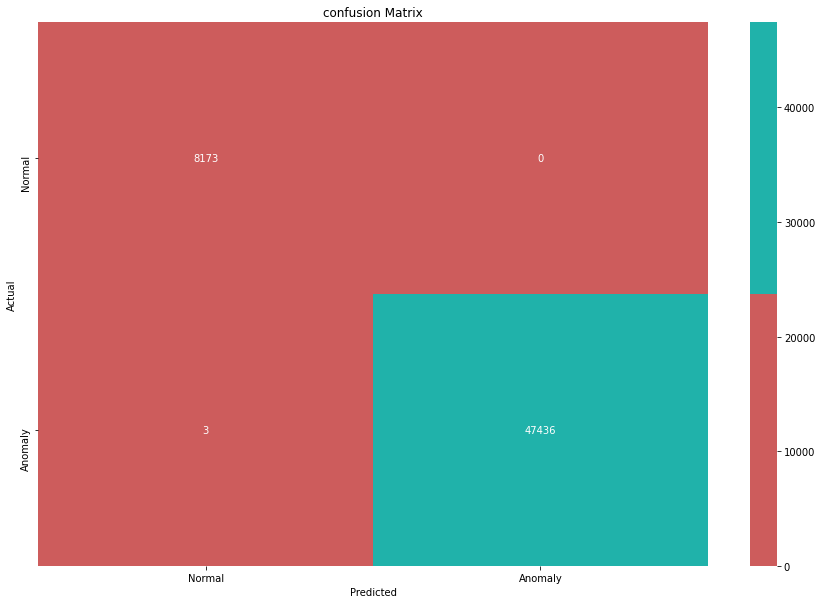

In [26]:
viz.drow_confusion_matrix(ytest,y_pred)

## Save the model

In [28]:
combination_model.save("./models/dae_cnn.h5")